# BF Classification

On the other notebook was attempted to make a regression to predic the body fat (BF) of a individual, and at the end we were able to find a Neural Network that gave a correlation between the prediction and the actual values of 0.7. It is a good result, but it could be better. For it we're assuming that the important thing is to know if your BF is low, normal or high so it will bacame a classification problem.

As I was reasearching for this I've found [this other dataset](https://www.kaggle.com/datasets/simonezappatini/body-fat-extended-dataset/code) which have more data and include females, so we're using it.

In [134]:
# Manipulation and vizualization librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing and model evaluation
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


# Opening the data and treating it

This dataset have two new collumns, one is sex of the person and the other is if the data is from the original dataset, as the latter is useless for the analysis we are delleting it.

In [135]:
data = pd.read_csv("bodyfat - Extended.csv")
data.describe()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,20.249839,34.545872,72.282203,1.734048,35.250917,94.158028,82.816055,98.652294,56.039679,37.365596,22.351835,29.897248,26.482110,17.139908
std,7.502125,15.500099,15.464366,0.098359,3.837908,10.931688,14.652729,6.895034,6.194143,2.768403,1.780513,3.944843,3.155306,1.582291
min,0.000000,1.000000,42.184800,0.750000,26.000000,43.000000,58.000000,82.500000,38.000000,24.700000,18.000000,20.500000,20.000000,13.500000
25%,15.022500,21.000000,59.875200,1.668780,31.500000,85.500000,70.000000,94.000000,51.500000,35.400000,21.000000,26.950000,23.700000,16.000000
50%,20.500000,28.500000,70.815800,1.730000,35.450000,93.050000,82.850000,98.300000,56.000000,37.500000,22.300000,29.800000,26.650000,17.300000
75%,25.410000,46.000000,81.560000,1.800000,38.300000,101.425000,93.225000,102.500000,60.000000,39.000000,23.300000,32.625000,29.200000,18.400000
max,47.500000,81.000000,164.720000,1.970000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


In [136]:
#deleting the original column
data.drop(columns=['Original'], inplace = True)

In [137]:
# Replacing the categorical data with numbers so we can train algorithms on it
encod_dict = {
    "M": 1,  # Replace "M" with 1
    "F": 0   # Replace "F" with 0
}

data = data.replace(encod_dict)
data.describe()

,BodyFat,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,20.249839,0.577982,34.545872,72.282203,1.734048,35.250917,94.158028,82.816055,98.652294,56.039679,37.365596,22.351835,29.897248,26.482110,17.139908
std,7.502125,0.494449,15.500099,15.464366,0.098359,3.837908,10.931688,14.652729,6.895034,6.194143,2.768403,1.780513,3.944843,3.155306,1.582291
min,0.000000,0.000000,1.000000,42.184800,0.750000,26.000000,43.000000,58.000000,82.500000,38.000000,24.700000,18.000000,20.500000,20.000000,13.500000
25%,15.022500,0.000000,21.000000,59.875200,1.668780,31.500000,85.500000,70.000000,94.000000,51.500000,35.400000,21.000000,26.950000,23.700000,16.000000
50%,20.500000,1.000000,28.500000,70.815800,1.730000,35.450000,93.050000,82.850000,98.300000,56.000000,37.500000,22.300000,29.800000,26.650000,17.300000
75%,25.410000,1.000000,46.000000,81.560000,1.800000,38.300000,101.425000,93.225000,102.500000,60.000000,39.000000,23.300000,32.625000,29.200000,18.400000
max,47.500000,1.000000,81.000000,164.720000,1.970000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


In [138]:
# Defining a function to classify the categories
def BodyFatClassifier(row):
  '''
  This function classifies the BodyFat column based on the Sex column.
  The classification values are not based on any scientific research. They're
  only values wich are commonly associated given category of body fat.

  '''
  if row['Sex'] == 1:
    if row['BodyFat'] < 10:
      return '0'
    elif 8 <= row['BodyFat'] < 20:
      return '1'
    elif 20 <= row['BodyFat'] < 30:
      return '2'
    else:
      return '3'
  if row['Sex'] == 0:
    if row['BodyFat'] < 20:
      return '0'
    elif 20 <= row['BodyFat'] < 30:
      return '1'
    elif 30 <= row['BodyFat'] < 40:
      return '2'
    else:
      return '3'

# Aplying the function and saving it on a new column
data['BodyFatClass'] = data.apply(BodyFatClassifier, axis=1).astype('category')

# Counting how many times a categorie appear on the column
data.BodyFatClass.value_counts()

BodyFatClass
1    191
2    110
0    109
3     26
Name: count, dtype: int64

In [139]:
# Now we make some final treatment to split the data
X = data.drop(['BodyFatClass', 'BodyFat'], axis=1)  # Features (excluding the 'BodyFat' and 'BodyFatClass' column)

scaler = StandardScaler()  # Standardize the features
X_scaled = scaler.fit_transform(X)  # Apply standardization to the features

pca = PCA()  # Inicialize the pca object
X_pca = pca.fit_transform(X_scaled)  # Apply PCA to the standardized features

y = data[['BodyFatClass']]  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Selecting the model

Now the problem is the selection of the model. To do this we create a function to evaliate the classification models present on the scikit library on the task of classifying this dataset

In [140]:
def test_classification_models(X, y):
    '''
    This function evaluates the performance of various classification models
    on the given dataset using cross validation. It takes the features (X) and
    target variable (y) as input and returns a DataFrame with the evaluation results.
    '''
    # Lists to store model names and corresponding evaluation scores
    names = []
    scores_accuracy = []
    scores_precision = []
    scores_recall = []
    scores_f1 = []

    # List of models
    classifiers = [
        ('LogisticRegression', LogisticRegression(max_iter=1000)),
        ('DecisionTreeClassifier', DecisionTreeClassifier()),
        ('RandomForestClassifier', RandomForestClassifier()),
        ('GradientBoostingClassifier', GradientBoostingClassifier()),
        ('MLPClassifier', MLPClassifier(max_iter=1000)),
        ('SVC', SVC()),
        ('GaussianNB', GaussianNB())
    ]

    # Loop through each classifier and evaluate its performance
    for name, clf in classifiers:
        names.append(name)  # Append the model's name to the list

        # Perform cross-validation and evaluate the model using various metrics
        cv_results = cross_validate(clf, X, y,
                                    scoring={
                                        'accuracy': make_scorer(accuracy_score),
                                        'precision': make_scorer(precision_score, average='weighted'),
                                        'recall': make_scorer(recall_score, average='weighted'),
                                        'f1': make_scorer(f1_score, average='weighted')
                                    })

        accuracy = cv_results['test_accuracy'].mean()
        precision = cv_results['test_precision'].mean()
        recall = cv_results['test_recall'].mean()
        f1 = cv_results['test_f1'].mean()

        # Append the evaluation scores to the respective lists
        scores_accuracy.append(accuracy)
        scores_precision.append(precision)
        scores_recall.append(recall)
        scores_f1.append(f1)

        # Print the evaluation results for each model
        print(f"Model's name: {name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Create a DataFrame to store the evaluation results
    data = pd.DataFrame({
        'names': names,
        'accuracy': scores_accuracy,
        'precision': scores_precision,
        'recall': scores_recall,
        'f1_score': scores_f1
    })

    return data


In [141]:
# Now we apply the function
results = test_classification_models(X, y)

# Here we use the whole dataset because we are avaliating the models using cross validation

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

Model's name: LogisticRegression - Accuracy: 0.5941, Precision: 0.6072, Recall: 0.5941, F1-Score: 0.5870
Model's name: DecisionTreeClassifier - Accuracy: 0.5345, Precision: 0.5378, Recall: 0.5345, F1-Score: 0.5256


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being

Model's name: RandomForestClassifier - Accuracy: 0.5574, Precision: 0.5623, Recall: 0.5574, F1-Score: 0.5416


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

Model's name: GradientBoostingClassifier - Accuracy: 0.5391, Precision: 0.5510, Recall: 0.5391, F1-Score: 0.5267


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0

Model's name: MLPClassifier - Accuracy: 0.5254, Precision: 0.5948, Recall: 0.5254, F1-Score: 0.4818


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

Model's name: SVC - Accuracy: 0.5277, Precision: 0.4855, Recall: 0.5277, F1-Score: 0.4659
Model's name: GaussianNB - Accuracy: 0.4270, Precision: 0.5681, Recall: 0.4270, F1-Score: 0.3988


In [142]:
# For better visualization we convert the results in to a DataFrame and then print it
pd.DataFrame(results)

,names,accuracy,precision,recall,f1_score
0,LogisticRegression,0.594122,0.607212,0.594122,0.587008
1,DecisionTreeClassifier,0.534483,0.537835,0.534483,0.525563
2,RandomForestClassifier,0.557393,0.562250,0.557393,0.541635
3,GradientBoostingClassifier,0.539080,0.550991,0.539080,0.526694
4,MLPClassifier,0.525366,0.594818,0.525366,0.481848
5,SVC,0.527717,0.485512,0.527717,0.465929
6,GaussianNB,0.426959,0.568060,0.426959,0.398793


# Fine tunnig the model

The logistic regression was the model that had best success in predicting the categorys. Because of this we're using it to move foward in this task.

Now it is needed to find better parameters than the standart one and to do it we are using a searchgrid whith some parameters

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: 

Best parameters found:  {'C': 0.01, 'l1_ratio': 0.0, 'max_iter': 100, 'penalty': 'none', 'solver': 'lbfgs'}
 the accuracy was: 0.68


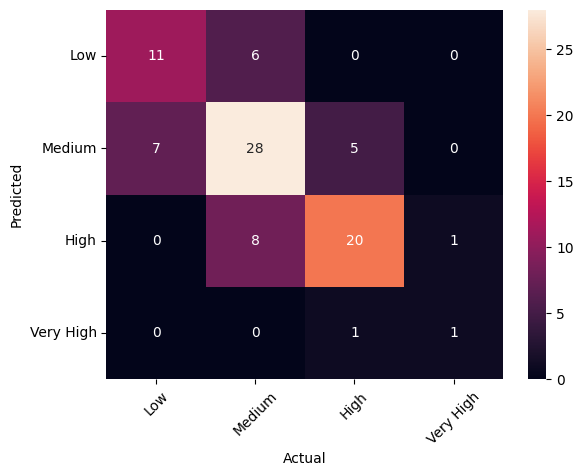

In [143]:
clf = LogisticRegression()

param_grid = {
    'penalty': ['l2', 'none'],  # Regularization terms
    'C': [0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300],  # Maximum number of iterations
}
# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("Best parameters found: ", grid_search.best_params_)

clf = grid_search.best_estimator_

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f' the accuracy was: {accuracy_score(y_test, y_pred):.2f}')

class_names = ['Low', 'Medium', 'High', 'Very High']

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.show()

# Conclusion

Besides our best efforts the performance of the model is average. The variation of body types are too large and the dataset is too small for high accuracy. A larger dataset is would be required if this was our goal.